<a href="https://colab.research.google.com/github/anshulvvv/Human-Image-Segmentation-using-UNET/blob/main/Human_Img_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
!git clone https://github.com/anshulvvv/Dataset-For-Image-Segmentation

Cloning into 'Dataset-For-Image-Segmentation'...
remote: Enumerating objects: 589, done.
remote: Counting objects: 100% (589/589), done.
remote: Compressing objects: 100% (588/588), done.
remote: Total 589 (delta 2), reused 585 (delta 1), pack-reused 0
Receiving objects: 100% (589/589), 13.60 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:

TRAIN_DATA_PATH = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
LR = 0.001
IMG_SIZE = 320
BATCH_SIZE = 24
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(TRAIN_DATA_PATH)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=57)

In [ ]:
import albumentations as A
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks


        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)


        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)


        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [ ]:

train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())

In [ ]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 232
Size of Validset : 58


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

In [ ]:

def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:

def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


MODEL SAVED
Epoch 1 Train Loss 0.9955278396606445 Val Loss 1.8417777220408122


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


MODEL SAVED
Epoch 2 Train Loss 0.4875847280025482 Val Loss 0.38461629549662274


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


MODEL SAVED
Epoch 3 Train Loss 0.3223811209201813 Val Loss 0.2627420326073964


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


MODEL SAVED
Epoch 4 Train Loss 0.2491301879286766 Val Loss 0.24575795729955038


100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


MODEL SAVED
Epoch 5 Train Loss 0.20925572961568834 Val Loss 0.21521268784999847


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch 6 Train Loss 0.17586332261562349 Val Loss 0.24384577572345734


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


MODEL SAVED
Epoch 7 Train Loss 0.1607905000448227 Val Loss 0.19678864379723868


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


MODEL SAVED
Epoch 8 Train Loss 0.1467598244547844 Val Loss 0.1941810498634974


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epoch 9 Train Loss 0.1297933652997017 Val Loss 0.19711479047934213


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


MODEL SAVED
Epoch 10 Train Loss 0.11941884532570839 Val Loss 0.18238003551959991


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


MODEL SAVED
Epoch 11 Train Loss 0.11295906379818917 Val Loss 0.18006456891695657


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 12 Train Loss 0.13074323534965515 Val Loss 0.2332861324151357


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epoch 13 Train Loss 0.11778763309121132 Val Loss 0.21822127203146616


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epoch 14 Train Loss 0.10512549653649331 Val Loss 0.18793751299381256


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


MODEL SAVED
Epoch 15 Train Loss 0.10143454670906067 Val Loss 0.17861045897006989


100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


MODEL SAVED
Epoch 16 Train Loss 0.08464686311781407 Val Loss 0.16633792718251547


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch 17 Train Loss 0.09056364521384239 Val Loss 0.191241055727005


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epoch 18 Train Loss 0.0817055206745863 Val Loss 0.1914822260538737


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epoch 19 Train Loss 0.08907856047153473 Val Loss 0.18138403197129568


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

Epoch 20 Train Loss 0.08934399485588074 Val Loss 0.18921521802743277


In [ ]:
model.load_state_dict(torch.load("best_model.pt"))


def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0))


    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0

    return image, mask, pred_mask

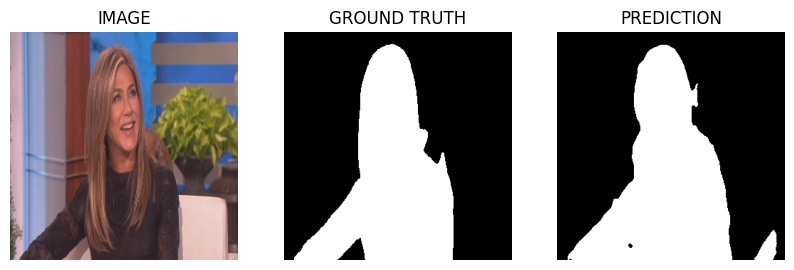

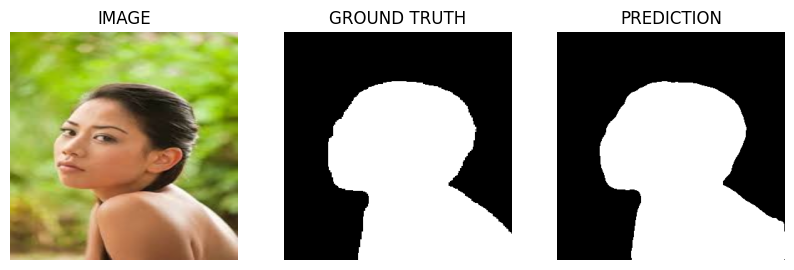

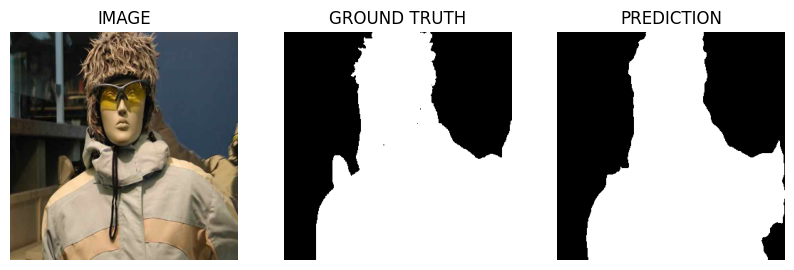

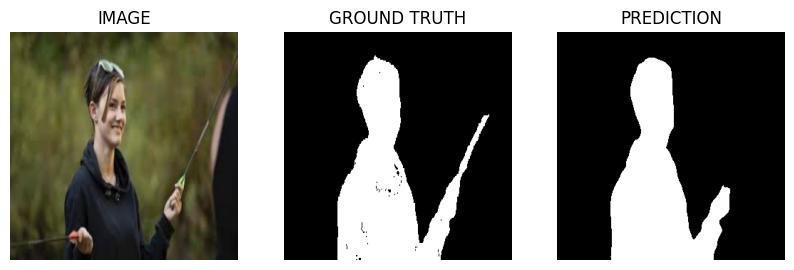

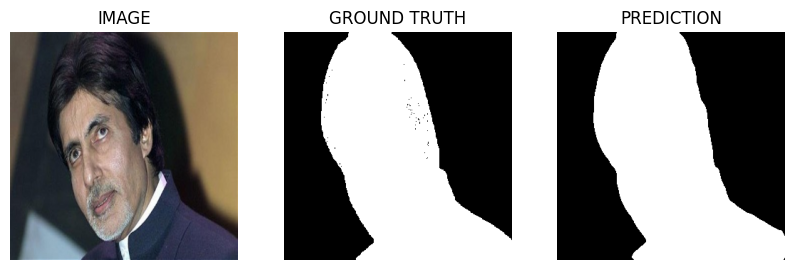

In [ ]:
for i in np.random.randint(0, len(val_data), 5):
    image, mask, pred_mask = make_inference(i)

    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');